In [1]:
import numpy as np
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
nruns=1
run='ntest'

selected_spsp = []
nzs = []
ndens = []
for i in range(nruns):
    selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))
    ndens.append(np.load("nz_samples/n_detected_"+run+"_"+str(i)+".npy"))

selected_spsp = np.vstack(selected_spsp)
nzs = np.vstack(nzs)
ndens = np.vstack(ndens)
print(selected_spsp.shape, nzs.shape, ndens.shape)

(8, 3) (8, 3) (8, 3)


In [3]:
def plot_nzs(axes, nzs, mean, density, a, p, **kwargs):

    ndropouts = 3

    percentile=p

    bin_step = 0.2
    bin_start = 0
    bin_end = 7

    bins = np.arange(bin_start, bin_end, bin_step)
    colours = ['blue', 'green', 'red']
    labels = ['$u$-dropouts', "$g$-dropouts", "$r$-dropouts"]
    lss=['--', '-.', '-']


    samples=100
    grid = np.arange(bin_start, bin_end-bin_step, bin_step/samples)

    for drop in range(ndropouts):

        values = []
        for ind in range(nzs.shape[0]):
            hist = np.histogram(nzs[ind][drop], density=density, bins=bins)
            oversampled_values = np.repeat(hist[0], samples)
            values.append(oversampled_values)

        values = np.vstack((np.array(values)))
        mean_at_grid_point = np.mean(values, axis=0)
        percentile_at_point = np.percentile(values, [100-percentile, 50, percentile], axis=0)
        if(mean):
            axes.plot(grid, mean_at_grid_point, c=colours[drop], **kwargs, label=labels[drop], ls=lss[drop], lw=2)
        axes.fill_between(grid, percentile_at_point[0, :], percentile_at_point[2, :], alpha=a, color=colours[drop], lw=0)

    axes.legend(fontsize=18, ncol=3, loc='upper left')
    axes.set_xlabel("Redshift $z$", fontsize=24)
    axes.set_ylabel("$p$($z$|Dropout Selection, SPS Model)", fontsize=24)
    axes.set_xticks(np.arange(0, 7, 0.5))
    axes.tick_params('x', labelsize=24)
    axes.tick_params('y', labelsize=24)
    axes.grid(alpha=0.2)
    axes.set_xlim(0, 6)
    axes.set_ylim(0, 1.8)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


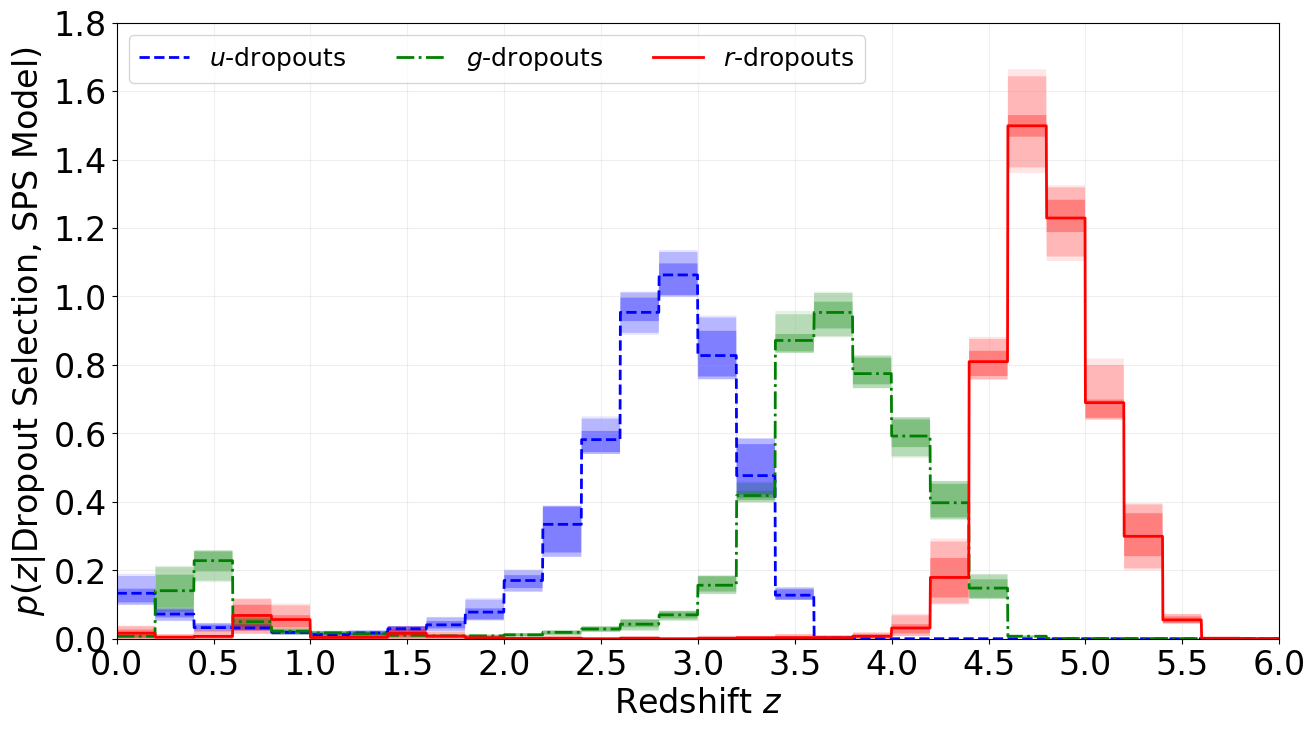

In [4]:
density=True
fig1, axes = plt.subplots(1, 1, figsize=(15,8), sharex=False, sharey=False)
plot_nzs(axes, nzs, mean=False, density=density, ls='--', a=0.1, p=99.7)
plot_nzs(axes, nzs, mean=False, density=density, ls='--', a=0.2, p=97.5)
plot_nzs(axes, nzs, mean=True, density=density, a=0.3, p=84)

In [5]:
def get_mass_less_8(seleced_sps, real):

    umasses = np.log10(np.squeeze(seleced_sps[real, 0])[:, -1])
    gmasses = np.log10(np.squeeze(seleced_sps[real, 1])[:, -1])
    rmasses = np.log10(np.squeeze(seleced_sps[real, 2])[:, -1])

    umasses8 = umasses[np.where(umasses < 8)[0]]
    gmasses8 = gmasses[np.where(gmasses < 8)[0]]
    rmasses8 = rmasses[np.where(rmasses < 8)[0]]

    upless8 = (len(umasses8)/len(umasses))*100
    gpless8 = (len(gmasses8)/len(gmasses))*100
    rpless8 = (len(rmasses8)/len(rmasses))*100

    return upless8, gpless8, rpless8

per_mass = np.zeros(3)
for indx in range(nzs.shape[0]):
    per_mass+=np.array(get_mass_less_8(selected_spsp, indx))

per_mass/nzs.shape[0]

array([2.66784657, 2.48071901, 0.40508304])

In [6]:
percentile=84
mean = np.mean(ndens, axis=0)
std =  np.std(ndens, axis=0)
errl = np.percentile(ndens, 100-percentile, axis=0)
errh = np.percentile(ndens, percentile, axis=0)

print("u-dropout number density (std): ",mean[0],"+/-",std[0],"deg-2")
print("g-dropout number density (std): ",mean[1],"+/-",std[1],"deg-2")
print("r-dropout number density (std): ",mean[2],"+/-",std[2],"deg-2")


ww_mag = [25.7022696929239, 26.503337783711615, 25.80373831775701]
ww_n = [14221.361534067577, 13866.10741847241, 1318.8615021762366]

print("W&W u-dropout number density: ",ww_n[0],"deg-2")
print("W&W g-dropout number density: ",ww_n[1],"deg-2")
print("W&W r-dropout number density: ",ww_n[2],"deg-2")

u-dropout number density (std):  8559.845262314138 +/- 991.1390258598021 deg-2
g-dropout number density (std):  13331.086674224363 +/- 1382.6757559605935 deg-2
r-dropout number density (std):  950.3109112012837 +/- 240.08993448126736 deg-2
W&W u-dropout number density:  14221.361534067577 deg-2
W&W g-dropout number density:  13866.10741847241 deg-2
W&W r-dropout number density:  1318.8615021762366 deg-2


u-dropout Interloper Fraction: 9.275378985713765 +/- 1.274168042890955
g-dropout Interloper Fraction: 10.116073361289713 +/- 1.9938738351607084
r-dropout Interloper Fraction: 3.7123882632657907 +/- 1.3687164345260368


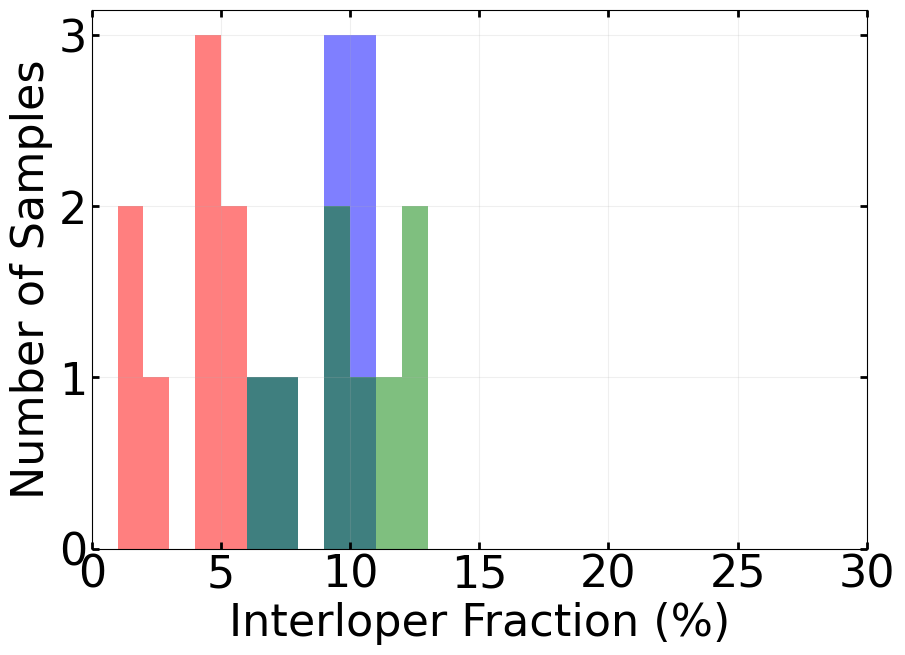

In [7]:
def interlopers(samples):
    nint = len(np.where(samples<2.0)[0])
    ntot = len(samples)
    return (nint/ntot)*100

f, ax = plt.subplots(1, 1, figsize=(10, 7))

uints = []
gints = []
rints = []
for n in range(nzs.shape[0]):
    uints.append(interlopers(nzs[n][0]))
    gints.append(interlopers(nzs[n][1]))
    rints.append(interlopers(nzs[n][2]))

nbins = np.arange(0.0, 100, 1)
histogram = ax.hist(uints, alpha=0.5, bins=nbins, color='blue')
histogram = ax.hist(gints, alpha=0.5, bins=nbins, color='green')
histogram = ax.hist(rints, alpha=0.5, bins=nbins, color='red')

uints_mean = np.mean(uints)
uints_std = np.std(uints)
gints_mean = np.mean(gints)
gints_std = np.std(gints)
rints_mean = np.mean(rints)
rints_std = np.std(rints)

print("u-dropout Interloper Fraction:", uints_mean,"+/-",uints_std)
print("g-dropout Interloper Fraction:", gints_mean,"+/-",gints_std)
print("r-dropout Interloper Fraction:", rints_mean,"+/-",rints_std)

ax.set_xticks(np.arange(0, 35, 5))

ax.set_xlim(0, 30)
ax.grid(alpha=0.2)
ax.set_xlabel("Interloper Fraction (%)", fontsize=32)
ax.set_ylabel("Number of Samples", fontsize=32)
ax.tick_params('x', labelsize=32, width=2, size=5, direction='in', top=True)
ax.tick_params('y', labelsize=32, width=2, size=5, direction='in', right=True)


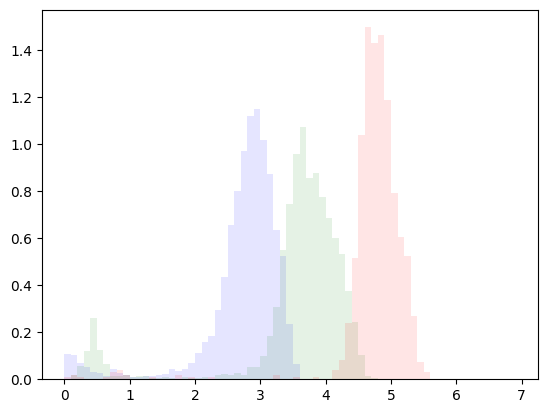

In [8]:
bins = nz.default_nz_bins()
indx=np.random.randint(0, nzs.shape[0])
hist = plt.hist(nzs[indx][0], density=True, bins=bins, alpha = 0.1, color='blue')
hist = plt.hist(nzs[indx][1], density=True, bins=bins, alpha = 0.1, color='green')
hist = plt.hist(nzs[indx][2], density=True, bins=bins, alpha = 0.1, color='red')

In [9]:
np.save("redshifts/emulated_redshifts_0.npy", nzs)